In [66]:
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab.rendering import ObservationToFeatureArray

import numpy as np
import pycolab
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

# Implementations

### Environments

#### 1. Blocking Maze

In [87]:
GOAL_LOCATION = (1, 9)
GAME_ART = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '######### #',
            '#         #',
            '#   P     #',
            '###########']


def make_game():
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(GAME_ART, what_lies_beneath=' ', sprites={'P': PlayerSprite})


class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.
    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location, the agent receives a reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')
    


    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things   # Unused in this application.

        # Apply motion commands.
        if actions == 0:    # walk upward?
            self._north(board, the_plot)
            #print('Walks up')
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
            #print('Walks down')
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
            #print('Walks left')
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)
            #print('Walks right')

        # See if we've found the mystery spot.
        if self.position == GOAL_LOCATION:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()

In [88]:
def show_board(obs):
    
    board = 10 * np.array(obs.layers['P'], dtype=np.float)
    board += 2 * np.array(obs.layers['#'], dtype=np.float)
    
    goal_mask = np.zeros(shape=board.shape)
    goal_mask[GOAL_LOCATION] = 1
    board += 7 * goal_mask

    plt.figure(figsize=(2,1))
    plt.imshow(board)
    plt.axis('off')
    plt.show()

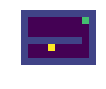

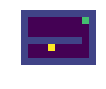

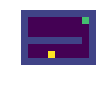

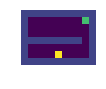

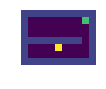

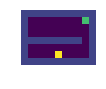

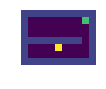

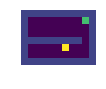

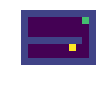

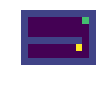

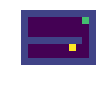

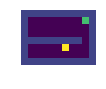

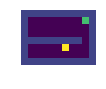

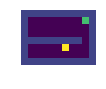

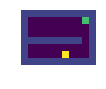

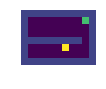

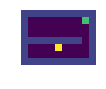

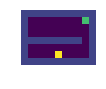

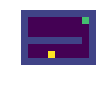

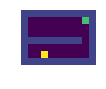

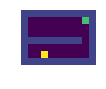

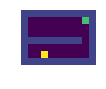

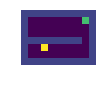

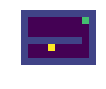

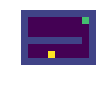

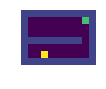

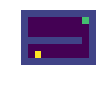

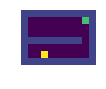

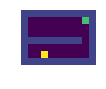

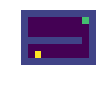

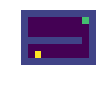

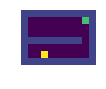

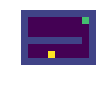

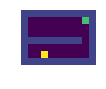

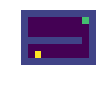

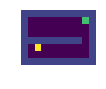

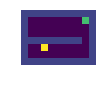

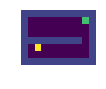

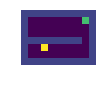

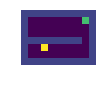

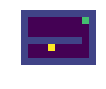

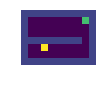

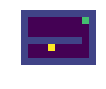

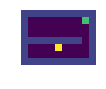

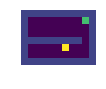

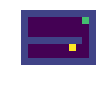

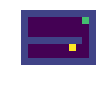

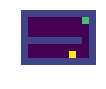

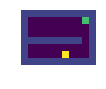

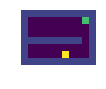

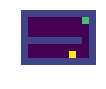

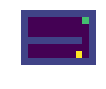

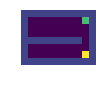

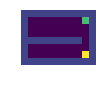

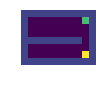

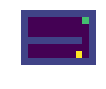

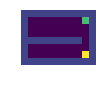

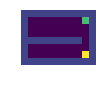

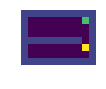

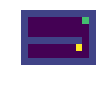

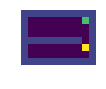

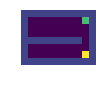

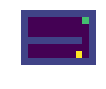

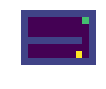

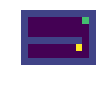

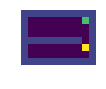

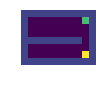

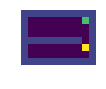

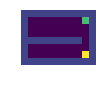

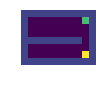

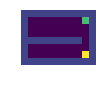

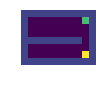

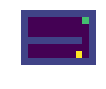

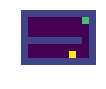

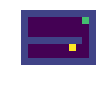

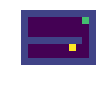

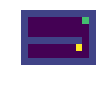

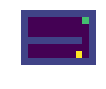

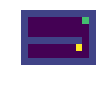

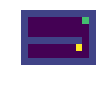

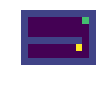

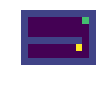

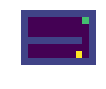

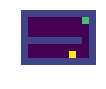

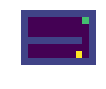

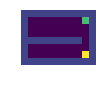

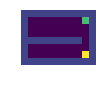

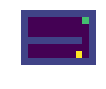

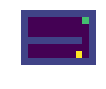

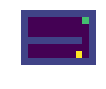

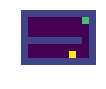

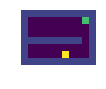

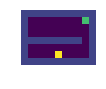

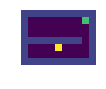

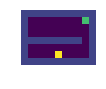

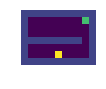

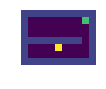

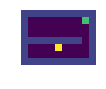

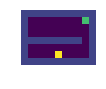

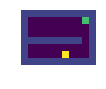

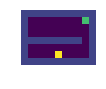

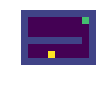

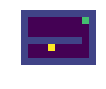

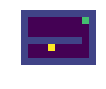

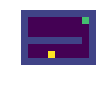

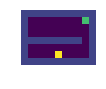

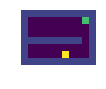

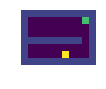

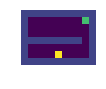

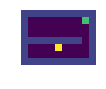

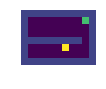

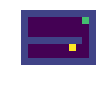

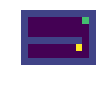

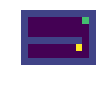

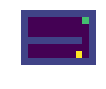

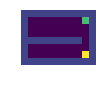

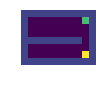

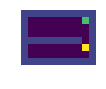

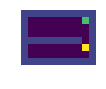

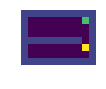

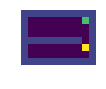

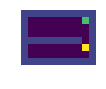

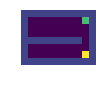

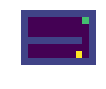

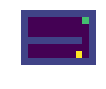

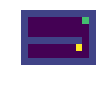

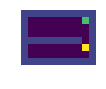

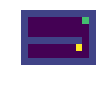

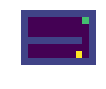

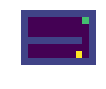

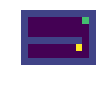

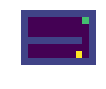

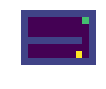

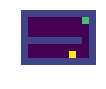

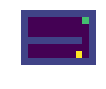

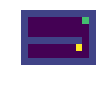

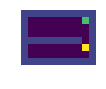

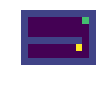

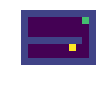

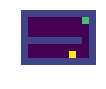

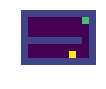

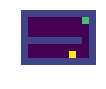

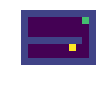

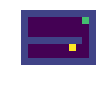

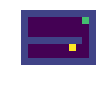

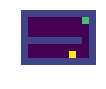

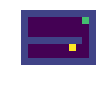

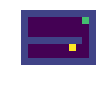

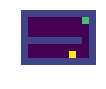

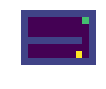

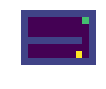

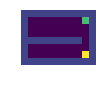

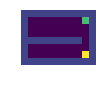

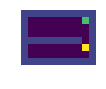

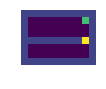

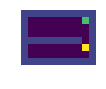

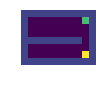

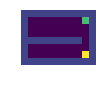

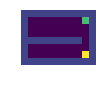

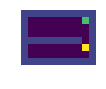

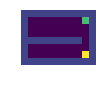

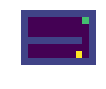

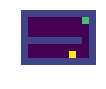

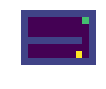

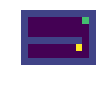

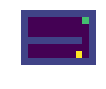

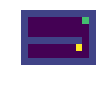

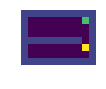

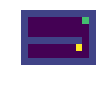

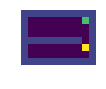

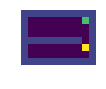

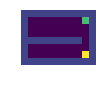

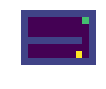

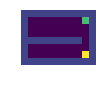

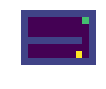

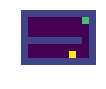

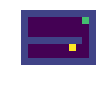

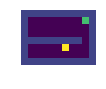

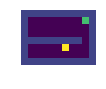

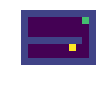

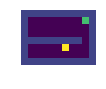

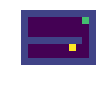

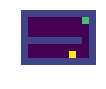

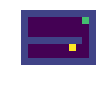

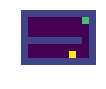

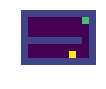

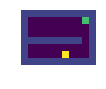

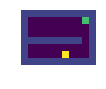

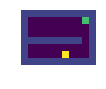

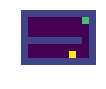

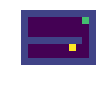

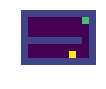

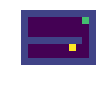

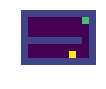

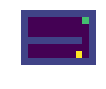

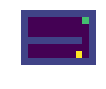

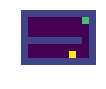

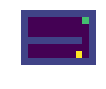

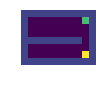

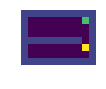

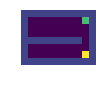

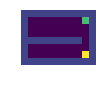

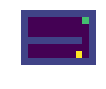

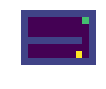

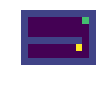

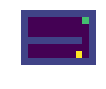

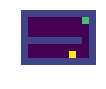

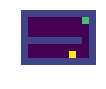

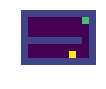

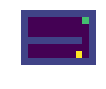

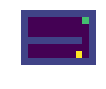

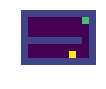

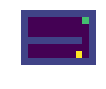

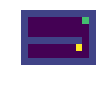

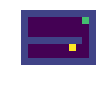

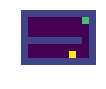

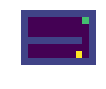

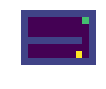

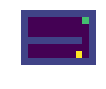

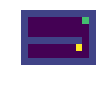

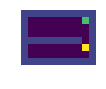

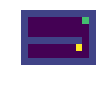

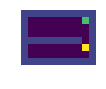

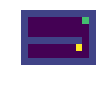

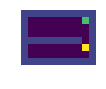

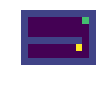

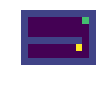

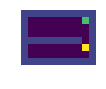

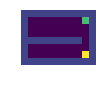

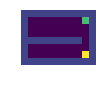

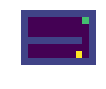

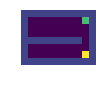

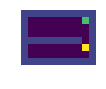

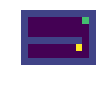

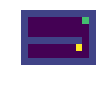

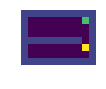

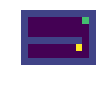

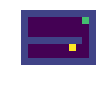

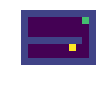

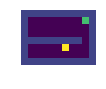

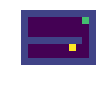

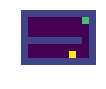

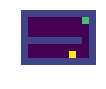

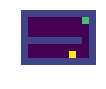

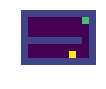

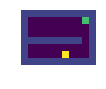

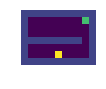

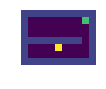

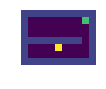

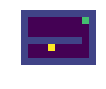

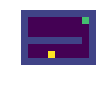

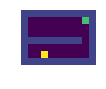

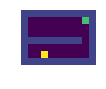

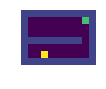

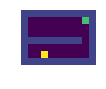

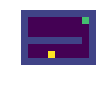

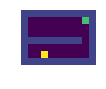

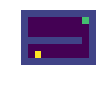

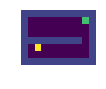

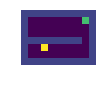

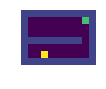

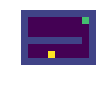

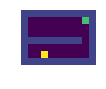

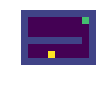

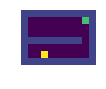

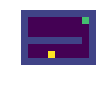

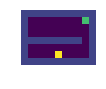

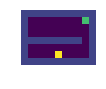

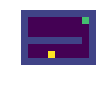

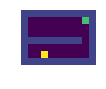

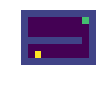

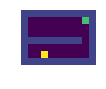

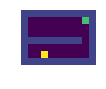

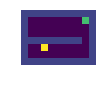

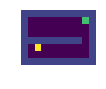

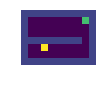

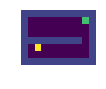

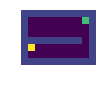

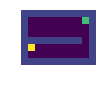

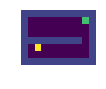

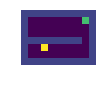

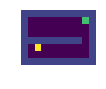

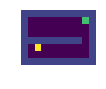

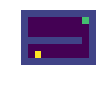

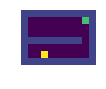

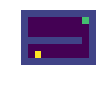

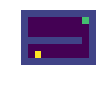

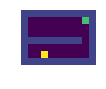

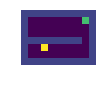

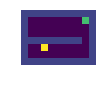

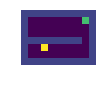

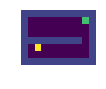

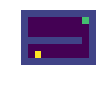

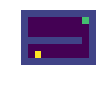

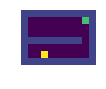

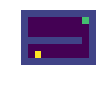

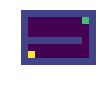

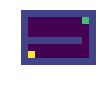

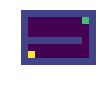

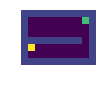

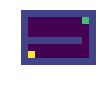

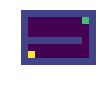

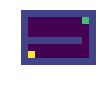

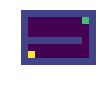

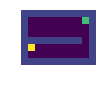

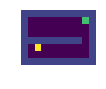

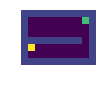

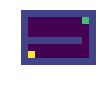

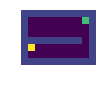

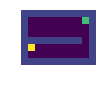

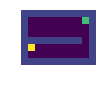

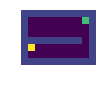

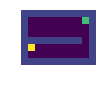

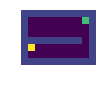

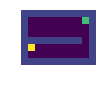

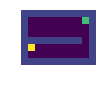

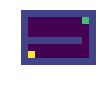

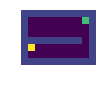

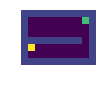

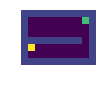

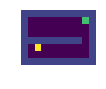

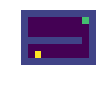

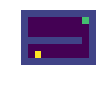

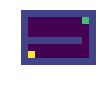

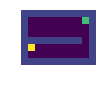

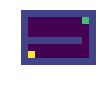

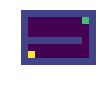

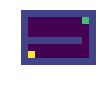

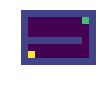

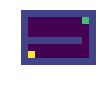

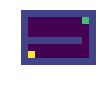

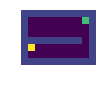

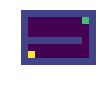

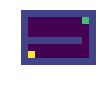

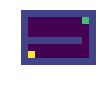

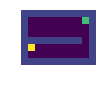

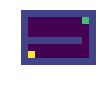

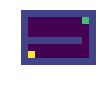

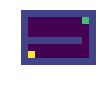

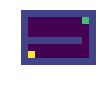

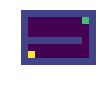

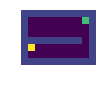

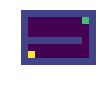

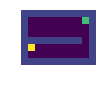

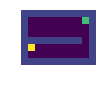

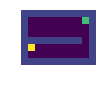

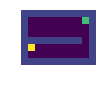

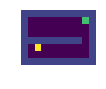

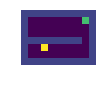

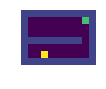

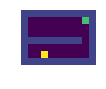

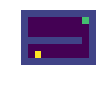

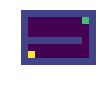

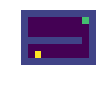

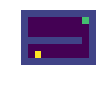

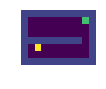

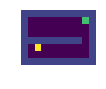

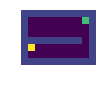

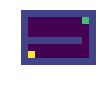

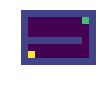

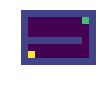

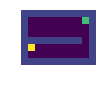

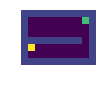

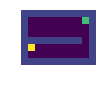

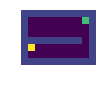

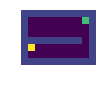

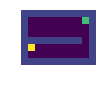

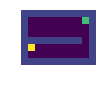

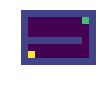

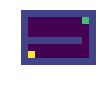

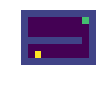

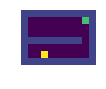

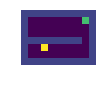

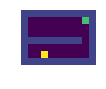

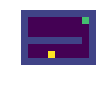

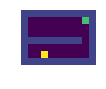

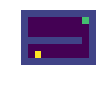

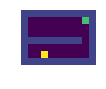

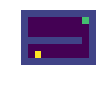

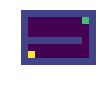

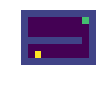

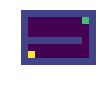

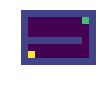

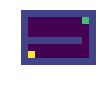

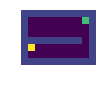

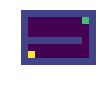

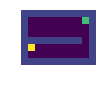

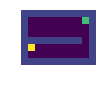

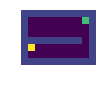

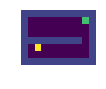

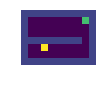

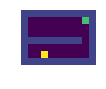

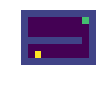

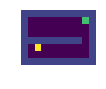

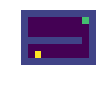

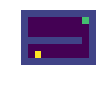

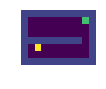

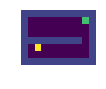

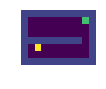

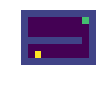

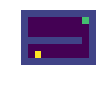

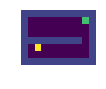

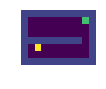

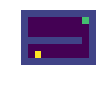

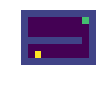

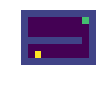

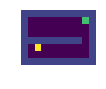

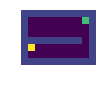

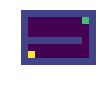

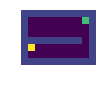

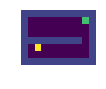

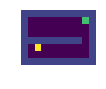

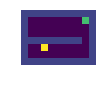

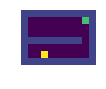

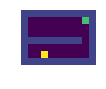

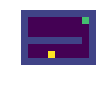

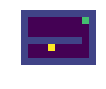

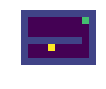

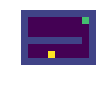

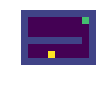

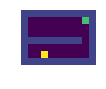

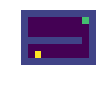

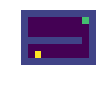

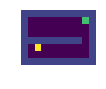

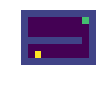

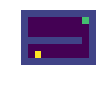

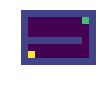

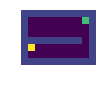

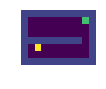

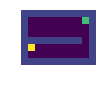

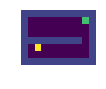

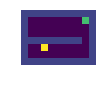

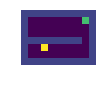

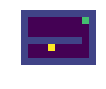

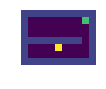

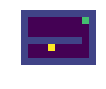

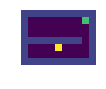

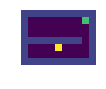

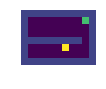

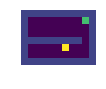

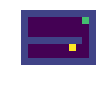

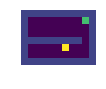

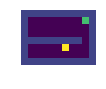

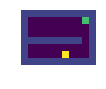

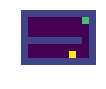

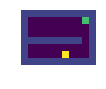

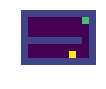

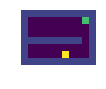

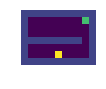

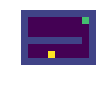

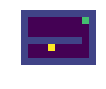

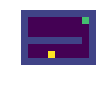

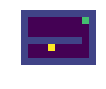

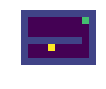

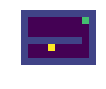

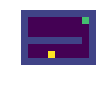

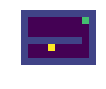

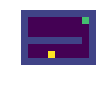

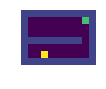

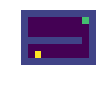

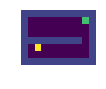

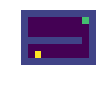

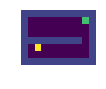

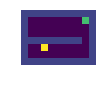

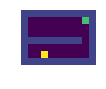

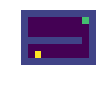

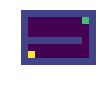

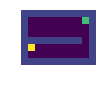

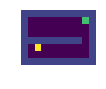

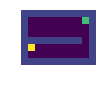

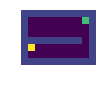

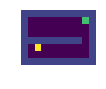

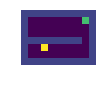

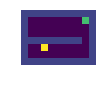

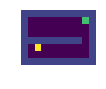

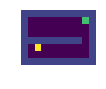

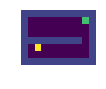

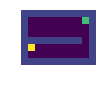

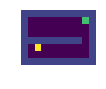

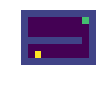

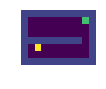

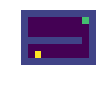

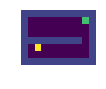

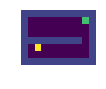

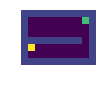

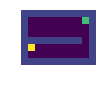

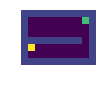

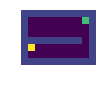

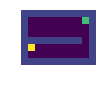

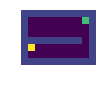

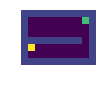

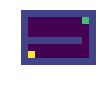

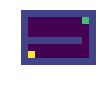

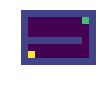

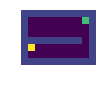

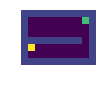

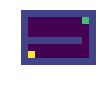

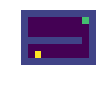

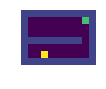

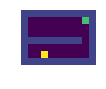

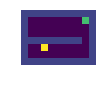

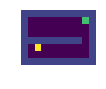

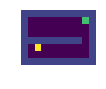

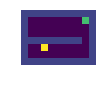

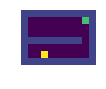

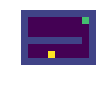

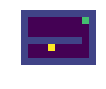

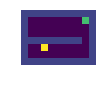

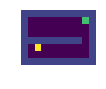

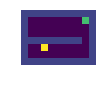

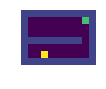

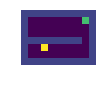

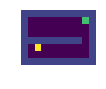

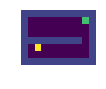

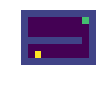

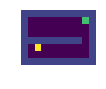

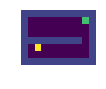

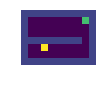

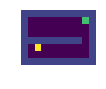

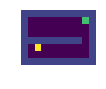

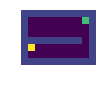

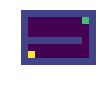

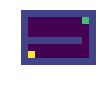

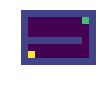

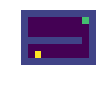

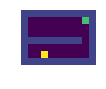

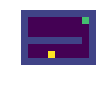

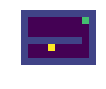

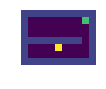

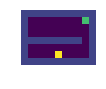

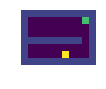

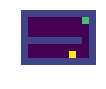

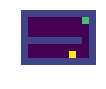

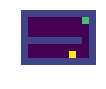

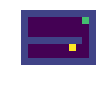

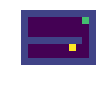

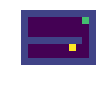

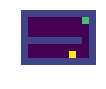

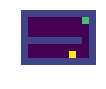

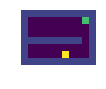

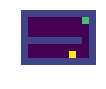

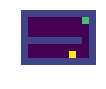

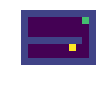

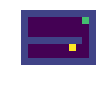

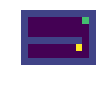

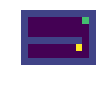

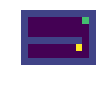

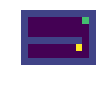

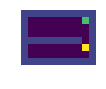

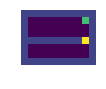

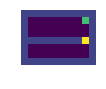

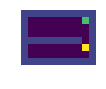

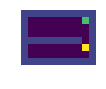

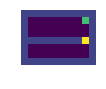

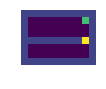

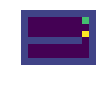

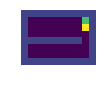

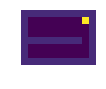

GAME OVER


In [90]:
# Instanciates our game object
game = make_game()

# Finalize the engine. Set-up and compute the first observation of the game
obs, reward, gamma = game.its_showtime();

# Take actions at random until termination
while not(game.game_over):
    a = np.random.randint(4)
    obs, reward, gamma = game.play(a)
    show_board(obs)
print('GAME OVER')

#### 2. Shortcut Maze

### Dyna-Q Algorithm

In [ ]:
def dynaQ():
    
    
    
    return

# Experiments

# How dows Dyna-Q relate to Experience Replay ?

# Conclusion